<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/research/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dependencies

In [1]:
!python3 -m pip install --upgrade pip
!python3 -m pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
			  torch \
              torchvision \
			  pycocotools \
			  pandas \
			  seaborn \
              torchviz -U && echo "Dependencies installation complete."

Dependencies installation complete.


## WandB login

In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wych (almtech). Use `wandb login --relogin` to force relogin


True

# Definitions

## Dataset Handler Definition

In [3]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 4

In [7]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

In [18]:
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import torch

class ResizeNormalize(object):
    def __init__(self, size: int, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size: list[int] = [size, size]
        self.mean = mean
        self.std = std

    def __call__(self, image, mask):
        image = F.resize(image, self.size)
        image = F.to_tensor(image)
        image = F.normalize(image, mean=self.mean, std=self.std)
        
        mask = F.resize(mask, self.size) # Important to keep it in nearest mode to not interpolate mask values.
        return image, mask  # Assuming image and mask to be PIL image

class CocoSegmentation(CocoDetection):
    def __init__(self, root_dir: str, ann_file: str, transforms=None):
        super(CocoSegmentation, self).__init__(root_dir, ann_file)
        self.transforms = transforms

    def __getitem__(self, index: int):
        image, targets = super(CocoSegmentation, self).__getitem__(index)

        # Convert binary masks to a single mask by assigning each instance a unique value (i.e., semantic segmentation mask)
        masks = [self.coco.annToMask(target) * (i + 1) for i, target in enumerate(targets)]
        mask = torch.as_tensor(np.sum(masks, axis=0), dtype=torch.int32)

        # Turning segmentation masks into a PyTorch tensor and expand dimensions
        mask = mask.unsqueeze(0)      
        
        print(type(image), type(mask))
        if self.transforms is not None:
            image, mask = self.transforms(image, mask)

        print(type(image), type(mask))
        return image, mask

In [19]:
from torch.utils.data import DataLoader

transform = ResizeNormalize(size=512)
dataset = CocoSegmentation(root_dir="dataset/train/",
                           ann_file="dataset/train/_annotations.coco.json",
                           transforms=transform)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [20]:
for batch in dataloader:
    imgs, labels = batch
    print(f"{imgs[0].shape} {labels[0].shape}")
    #display(tensor_to_pil(imgs[0] * 255))
    #display(tensor_to_pil(masks[0] * 40))
    display(tensor_to_pil(imgs[0]*100 + labels[0]*120))
    break

TypeError: Unexpected type <class 'list'>

## FeynMAN Model Definition

In [3]:
import torch.nn as nn
import torchvision.models as models

class FeynMAN(nn.Module):
    def __init__(self, num_classes: int = 3):
        super(__class__, self).__init__()

        self.backbone = models.segmentation.fcn_resnet50(pretrained=False, num_classes=num_classes)  # untrained FCN_ResNet50

    def forward(self, x):
        return self.backbone(x)

# Training

In [9]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

Mon Sep 25 12:19:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8              19W / 140W |    466MiB /  6144MiB |     29%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataloader: DataLoader,
    epochs: int = EPOCHS,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
):
    # Watch the model for cool weights & biases
    wandb.watch(model)

    # Loss function and optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()

    # Convert model to "device space"
    model = model.to(device)

    # Start training
    model.train()
    print("BEGIN TRAINING!")

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            print("Running batch: ", batch_idx)
            
            # Forward pass
            print(" - Forward pass")
            outputs = model(inputs)["out"]
            print(" - Loss calc")
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            print(" - Zero grad")
            optimizer.zero_grad()
            print(" - Backward prop")
            loss.backward()
            print(" - Optim step")
            optimizer.step()

            running_loss += loss.item()
            wandb.log({"loss": loss})

            print(
                f" # Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )

            del inputs, labels

        wandb.log({"running_loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [8]:
model = FeynMAN()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
#device_type = "cpu"
device = torch.device(device_type)

# start a new wandb run to track this script
wandb.init(
	# set the wandb project where this run will be logged
	project="feynman_0",

	# track hyperparameters and run metadata
	config={
	"learning_rate": LEARNING_RATE,
	"epochs": EPOCHS,
	"batch_size": BATCH_SIZE,
	"architecture": "FeynMAN fcn_resnet50",
	"dataset": "feynman_v9i",
	}
)

/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/elal/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Start training loop

#### Train the model

In [9]:
# Fix for some CUDA bullshit

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [10]:
print(f"Doing training on device type '{device_type}'!")
torch.cuda.empty_cache()
train_model(model, dataloader=dataloader, device=device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Doing training on device type 'cuda'!
BEGIN TRAINING!
Running batch:  0
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [1/52] - Loss: 0.8097
Running batch:  1
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [2/52] - Loss: 0.3849
Running batch:  2
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [3/52] - Loss: 0.4984
Running batch:  3
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [4/52] - Loss: 0.5242
Running batch:  4
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [5/52] - Loss: 0.6169
Running batch:  5
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [6/52] - Loss: 0.6347
Running batch:  6
 - Forward pass
 - Loss calc
 - Zero grad
 - Backward prop
 - Optim step
 # Epoch [1/100] Batch [7/52] - Loss: 0

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
running_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00044
running_loss,0.04408


In [11]:
torch.save(model, "models/feynman.pth")

## Test the model

In [4]:
import torch

model = torch.load("models/feynman.pth")

In [5]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
cpu_device = torch.device("cpu")

In [12]:
del result

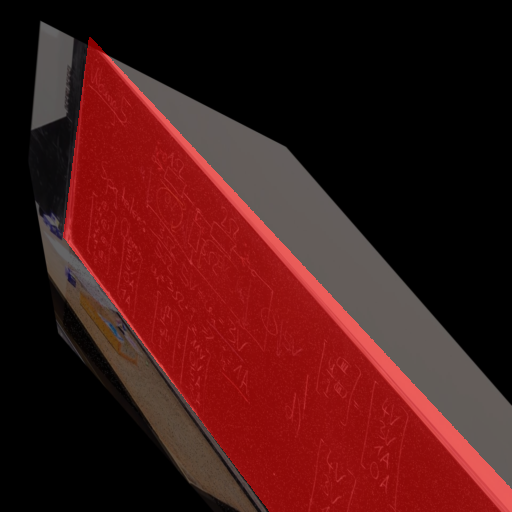

VS
tensor([[[[-0.0204, -0.0204, -0.0204,  ..., -0.7336, -0.7336, -0.7336],
          [-0.0204, -0.0204, -0.0204,  ..., -0.7336, -0.7336, -0.7336],
          [-0.0204, -0.0204, -0.0204,  ..., -0.7336, -0.7336, -0.7336],
          ...,
          [ 0.5330,  0.5330,  0.5330,  ...,  3.0810,  3.0810,  3.0810],
          [ 0.5330,  0.5330,  0.5330,  ...,  3.0810,  3.0810,  3.0810],
          [ 0.5330,  0.5330,  0.5330,  ...,  3.0810,  3.0810,  3.0810]],

         [[ 2.5369,  2.5369,  2.5369,  ...,  5.3519,  5.3519,  5.3519],
          [ 2.5369,  2.5369,  2.5369,  ...,  5.3519,  5.3519,  5.3519],
          [ 2.5369,  2.5369,  2.5369,  ...,  5.3519,  5.3519,  5.3519],
          ...,
          [ 3.1215,  3.1215,  3.1215,  ...,  1.1170,  1.1170,  1.1170],
          [ 3.1215,  3.1215,  3.1215,  ...,  1.1170,  1.1170,  1.1170],
          [ 3.1215,  3.1215,  3.1215,  ...,  1.1170,  1.1170,  1.1170]],

         [[-3.1084, -3.1084, -3.1084,  ..., -4.0106, -4.0106, -4.0106],
          [-3.1084, -3.1084

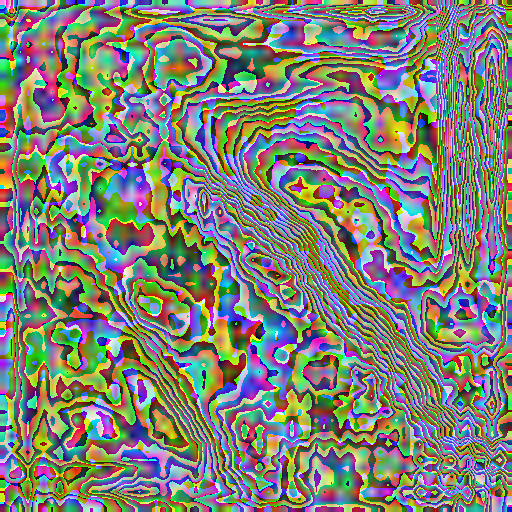

In [10]:
model = model.to(device)

img, label = dataset[0]
display(tensor_to_pil(img*100 + label*120))

print("VS")

img = img.to(device)
outputs = model(img.unsqueeze(0))
result = outputs["out"].to(cpu_device)

del img

print(result)
pic = tensor_to_pil(result.squeeze(0))
print(type(pic), pic)
display(pic)